In [1]:
from numpy.random import seed
import numpy as np
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

import tensorflow as tf
# from tensorflow.python.keras.optimizers import Fire
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import optimizers

from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import log_loss

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
from torchsummary import summary


import matplotlib.pyplot as plt
%matplotlib inline


## Preparing the input data

In [2]:
#Preparing the input data

#loading the MNIST dataset
mnist = tf.keras.datasets.mnist

#Separating into train and test (60000 train, 10000 test)
(x_train, y_train0),(x_test, y_test0) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

#flattening the images (from 28x28 to 784)
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)


#converting the otputs (labels) into one hot vectors
lb = preprocessing.LabelBinarizer()
lb.fit(np.array([0,1,2,3,4,5,6,7,8,9]))
y_train = lb.transform(y_train0)
y_test = lb.transform(y_test0)


## Defining the input parameters


In [3]:
#Defining the input parameters
BatchSize         = 500
NeuronsLayer1     = 100
NeuronsLayer2     = 100
Epochs            = 100

## PyTorch

In [4]:
# Create Tensors to hold inputs and outputs

torch_X_train = torch.from_numpy(x_train)
torch_y_train = torch.from_numpy(y_train)

#the trainloader helps us deal with the batches
train = torch.utils.data.TensorDataset(torch_X_train.float(),torch_y_train.float())
train_loader = torch.utils.data.DataLoader(train, batch_size = BatchSize, shuffle = False)


In [5]:
# Defining the net

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,NeuronsLayer1)
        self.linear2 = nn.Linear(NeuronsLayer1,NeuronsLayer2)
        self.linear3 = nn.Linear(NeuronsLayer2,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = F.softmax(self.linear3(X), dim=1)
        return X



In [6]:
# Construct our model by instantiating the class defined above.
model = MLP()


# Construct our loss function and an Optimizer. 

#it seems that cateorical cross-entropy is not available in pytorch. We have to make or own
#    implementation of the loss function
#https://datascience.stackexchange.com/questions/55962/pytorch-doing-a-cross-entropy-loss-when-the-predictions-already-have-probabiliti
def categorical_cross_entropy(y_pred, y_true):
    y_pred = torch.clamp(y_pred, 1e-9, 1 - 1e-9)
    return -(y_true * torch.log(y_pred)).sum(dim=1).mean()

optimizer = torch.optim.Adam(model.parameters())


In [7]:
#Show aprameters of the network
model.parameters

<bound method Module.parameters of MLP(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)>

In [8]:
#train the network

loss_history = []
for epoch in range(Epochs):
    loss_avg = 0.0
    N_elements = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(X_batch)

        # Compute loss
        loss = categorical_cross_entropy(y_pred, y_batch)

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_avg += loss.item()*X_batch.size()[0]
        N_elements += X_batch.size()[0]

    # print loss after each epoch    
    print(epoch+1, loss.item(), loss_avg/N_elements)
    loss_history.append(loss_avg/N_elements)


1 0.2693708837032318 0.743281010662516
2 0.21981947124004364 0.2772692972794175
3 0.19280613958835602 0.2158559529731671
4 0.17550921440124512 0.1791273138175408
5 0.16534960269927979 0.1535166815544168
6 0.15742802619934082 0.13422945123165847
7 0.14997263252735138 0.11879941740383705
8 0.14199405908584595 0.10619592033326626
9 0.13392777740955353 0.09573884656031927
10 0.1260603666305542 0.08651566961780191
11 0.11908599734306335 0.07860302540163198
12 0.1111280545592308 0.0715199768388023
13 0.10289566218852997 0.06518746381625533
14 0.0940386950969696 0.05967147024348378
15 0.08516008406877518 0.0546204901766032
16 0.07843393087387085 0.04993509304088851
17 0.07150780409574509 0.04575526515642802
18 0.06507837772369385 0.04206505216037234
19 0.0596977099776268 0.038715300639159976
20 0.05255799740552902 0.03564774300903082
21 0.046331822872161865 0.032808993097084266
22 0.03918847441673279 0.030123332538641988
23 0.0335158035159111 0.02770062449077765
24 0.027444036677479744 0.0254

In [9]:
#Predicting
y_train_hat_Pytorch = model(torch_X_train.float()).detach().numpy()

print(log_loss(y_train, y_train_hat_Pytorch))
# print(categorical_cross_entropy(torch.from_numpy(y_train).float(), torch.from_numpy(y_train_hat_Pytorch)))

4.9600766990670783e-05


In [10]:
print(y_train[0])
print(y_train[1])

[0 0 0 0 0 1 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]


In [11]:
print(y_train_hat_Pytorch[0])
print(y_train_hat_Pytorch[1])

[2.1013711e-31 4.1455269e-23 1.5996665e-20 6.6180510e-05 0.0000000e+00
 9.9993384e-01 1.8145858e-32 1.0823392e-27 2.8055580e-32 3.1600519e-21]
[1.0000000e+00 5.4496440e-35 9.2110968e-16 6.1589742e-28 2.9754415e-39
 3.3539346e-27 2.4967089e-24 8.7443980e-26 2.3347575e-30 1.7749837e-23]


In [12]:
#Show aprameters of the network

summary(model, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
            Linear-2               [-1, 1, 100]          10,100
            Linear-3                [-1, 1, 10]           1,010
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.34
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


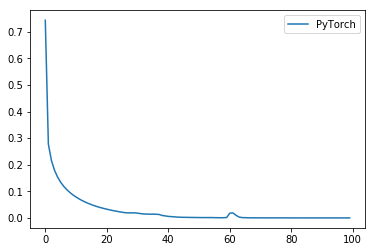

In [13]:
fig, ax = plt.subplots(1,1)
ax.plot(loss_history, label="PyTorch")
ax.legend()

